In [1]:
import glob
import numpy as np
import pandas as pd 
%matplotlib inline
# produce vector inline graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import rasterio as rio
import rasterio.mask
import csv
import shapely.wkt as wkt
import math as m
from scipy.constants import c as speed_of_light
import random

def conf_int(data, axis=0, alpha=0.95, weights=None):
    data = np.array(data)
    if not weights:
        return scipy.stats.sem(data, axis=axis) * scipy.stats.t.ppf((1 + alpha) / 2., data.shape[axis]-1)
    else:
        mean = np.average(data, axis=axis, weights=weights)
        stdev = np.sqrt(np.average((data-mean)**2, weights=weights, axis=axis))
        sem = stdev/np.sqrt(data.shape[axis])
        return sem * scipy.stats.t.ppf((1 + alpha) / 2., data.shape[axis]-1)

def std(data, axis=0, weights=None):
    data = np.array(data)
    if not weights:
        return np.std(data, axis=axis)
    else:
        mean = np.average(data, axis=axis, weights=weights)
        stdev = np.sqrt(np.average((data-mean)**2, weights=weights, axis=axis))
        return stdev




#PARAMS
area = 'luxemburg'
sub_area_id = '0'
max_dist =  300

#RF params
h_bs = 10
h_ut = 1.5
epsg = 3003
kb = 1.380649*(10**-23)  # J/K
temp = 300  # K
nf = 5
fronthaul_bandwidth = 400e6 #Hz
fronthaul_mimo = 2
frequency = 28 #Ghz
tx_power = 30
tx_gain = 10
rx_gain_fronthaul = 3  # need to find a reference

/tmp/ipykernel_915041/3090532007.py:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


In [6]:
#small area (2)
sub_area = wkt.loads("POLYGON ((76149.3828127647 73922.4335140161,76110.5488176897 74065.2871387564,75745.7866496635 74733.7866254053,75974.6298349271 74830.8716130929,76478.084842507 75002.8507341395,76532.175049933 74790.6506896223,76514.144980791 74653.3447784641,76514.144980791 74529.9081512613,76584.8783289634 74276.100254878,76451.7332029918 73934.9158695759,76149.3828127647 73922.4335140161))")
#big area (0)
sub_area = wkt.loads("MULTIPOLYGON (((77462.8497438607 73703.6291953883,75345.6534984474 73935.3621177719,75366.720127755 74009.0953203485,74843.5654999498 74153.050620617,74836.5432901806 74184.6505645784,74889.2098634495 74542.7832628075,74854.0988146036 74985.182478267,74861.1210243728 75301.1819178809,74882.1876536804 75536.4259451491,74959.4319611415 75813.8032310324,76511.3403201343 75448.6483230341,76967.7839551322 75329.2707569577,76985.3394795552 74995.7157929208,77564.671785514 74005.5842154639,77462.8497438607 73703.6291953883)))")


folders = glob.glob('/mnt/ric_dais_nfs_maccari/gabriel/results/ComComVSI/*')
targets = {}
transforms_tgt = {}
for f in folders:
    t = f.split(sep='/')[-1][8:]
    dataset = rio.open(f'/mnt/ric_dais_nfs_maccari/gabriel/data/dtm_fusion/luxemburg_{t}_mask.tif', 'r', crs='EPSG:2169')
    raster, transform =  rio.mask.mask(dataset, [sub_area], crop=True, indexes=1)    
    targets[t] = raster
    transforms_tgt[t] = transform

dtm_dataset = rio.open(f'/mnt/ric_dais_nfs_maccari/gabriel/data/dtm_fusion/{area}_dtm.tif')
with open(f'../areas/{area}.csv') as sacsv:
    subareas_csv = list(csv.reader(sacsv, delimiter=','))
    for sa in subareas_csv:
        if sa[1].strip() == sub_area_id:
            sub_area = wkt.loads(sa[0])
            buffered_area = sub_area.buffer(max_dist/2)
            dataset_crop, rm_transform = rio.mask.mask(dtm_dataset, [buffered_area], crop=True, indexes=1)
            dataset_unb_crop, rm_unb_transform = rio.mask.mask(dtm_dataset, [sub_area], crop=True, indexes=1)


def mytransf(points, transform1, transform2):
    rows, cols = list(zip(*points))
    newrows, newcols = rio.transform.rowcol(transform1, *rio.transform.xy(transform2, rows, cols))
    return list(zip(newrows, newcols))

In [3]:
from numba import vectorize, float64, uint8

@vectorize([float64(float64, uint8)])
def pathloss(d, los):
    # ETSI TR38.901 Channel Model
    if d < 10: # Model is undefined for d<10
        d = 10  
    breakpoint_distance = 2*m.pi*h_bs*h_ut*frequency*1e9/speed_of_light
    if d < breakpoint_distance:
        pl_los = 32.4 + 21*m.log10(d)+20*m.log10(frequency)  # + nrv_los.rvs(1)[0]
    else:
        pl_los = 32.4 + 40*m.log10(d)+20*m.log10(frequency) - 9.5*m.log10((breakpoint_distance)**2 + (h_bs-h_ut)**2)  # + nrv_los.rvs(1)[0]

    pl_nlos = 22.4 + 35.3*m.log10(d)+21.3*m.log10(frequency) - 0.3*(h_ut - 1.5)  # + nrv_nlos.rvs(1)[0]

    if los:
        return pl_los
    else:
        return max(pl_los, pl_nlos)

def get_shannon_capacity(los, d):
    loss = tx_power + tx_gain - pathloss(d, los) + rx_gain_fronthaul
    noise = 10*m.log10(1000*kb*temp*fronthaul_bandwidth)
    snr =  loss - noise  - nf
    lin_snr = 10**(snr/10)
    bw = fronthaul_mimo*fronthaul_bandwidth*np.log2(1+lin_snr) * 10**-6 #to get Mbps
    return bw

def get_max_capacity(los, dist):
    #compute shannon capacity on the matrix
    capacities = get_shannon_capacity(los, dist)
    pl = pathloss(dist, los)
    #set capacity 0 to links longer than max_dist
    capacities = np.where(dist>max_dist, 0, capacities)
    
    #get bs_ids that correspond to max capacity for each point (over bs axis)
    bs_i = np.expand_dims(np.argmax(capacities, axis=0), axis=0)
    #get maximum capacities
    max_c = np.take_along_axis(capacities, bs_i, axis=0)[0]
    #get pathloss of those points
    min_pl = np.take_along_axis(pl, bs_i, axis=0)[0]
    #get dist of those points
    max_dists = np.take_along_axis(dist, bs_i, axis=0)[0]
    #get visibility of those points
    los_chosen = np.take_along_axis(los, bs_i, axis=0)[0]
    #reverse to get non visibiltiy
    nlos_chosen = np.where(los_chosen==1, 0, 1)
    #get capacity for los link
    capacities_los = np.multiply(max_c, los_chosen)
    #get capacity for nlos link
    capacities_nlos = np.multiply(max_c, nlos_chosen)
    #get links that i chose to be nlos even if there was a los (capacity nlos>los)
    p_los = np.bitwise_or.reduce(los, axis=0)
    tr_nlos = np.bitwise_xor(p_los, los_chosen)
    # print(p_los.shape)
    # print(tr_nlos.shape)
    return max_c, capacities_los, capacities_nlos, max_dists, los_chosen, min_pl, tr_nlos, p_los

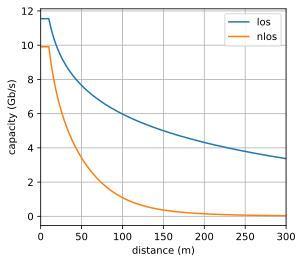

In [4]:
def plot(plos):
    loss = tx_power + tx_gain - plos + rx_gain_fronthaul
    noise = 10*m.log10(1000*kb*temp*fronthaul_bandwidth)
    snr =  loss - noise  - nf
    lin_snr = 10**(snr/10)
    bw = fronthaul_mimo*fronthaul_bandwidth*np.log2(1+lin_snr) * 10**-9
    return np.array([loss, snr, bw])

x = np.linspace(0,300, 1000)
pl_los = plot(pathloss(x, 1))
pl_nlos = plot(pathloss(x, 0))

plt.figure(figsize=(15,4))
for i in range(2,3):
    ax = plt.subplot(1,3,i+1)
    if i == 0:
        ax.set_ylabel('pathloss (dB)')
    elif i== 1:
        ax.set_ylabel('SNR (dB)')
    elif i == 2:
        ax.set_ylabel('capacity (Gb/s)')

    ax.set_xlabel("distance (m)")
    ax.plot(x, pl_los[i,:], label='los')
    ax.plot(x, pl_nlos[i,:],  label='nlos')
    ax.grid()
    ax.set_xlim(0, 300)
#plt.ylabel('capacity (Mbps)')
#plt.yscale('log')

plt.legend()
# lin_snr = 10**(25/10)
# np.log2(1+lin_snr)#* 10**-9

In [5]:
from numba import cuda
import warnings
warnings.simplefilter("ignore")

#warnings.filters()
def cuda_los(viewsheds, np_points, nodes):
    los=cuda.device_array(shape=(len(nodes), len(np_points)), dtype=np.uint8)
    threadsperblock = (16, 16)
    blockspergrid_x = m.ceil(los.shape[0] / threadsperblock[0])
    blockspergrid_y = m.ceil(los.shape[1] / threadsperblock[1])
    blockspergrid = (blockspergrid_x, blockspergrid_y)
    gen_los[blockspergrid, threadsperblock](los, viewsheds, np_points)
    return los.copy_to_host()

@cuda.jit()
def gen_los(los, viewsheds, np_points):
    i, j = cuda.grid(2)
    if i<los.shape[0] and j<los.shape[1]:
        los[i,j] = viewsheds[i,  np_points[j, 0], np_points[j,1]]


In [8]:
runs = glob.glob(f'/mnt/ric_dais_nfs_maccari/gabriel/results/ComComVSI/*/{area}/threestep/{sub_area_id}/r1/1/100.0/*/')
res = []
res_un = []
for r in runs[:]:
    #print(r)
    prefix, subpath = r.split('results_')
    params =  subpath.split('/')
    base, area, strat, sa, rf, k, ratio, dens = params[0:-1]
    #print(base, dens)
    if base not in ['sidewalkparks', 'cars_sumo_nonorm', 'cars_sumo']:
        continue
    bp = prefix+'results_'+'/'.join(params[:4])
    common_d = {'area': area, 'base': base, 'dens': int(dens)}
    try:
        nodes = pd.read_csv(f'{r}/index.csv', 
                            sep=' ', 
                            header=None, 
                            names=['x', 'y', 'z', 'x_3003', 'y_3003', 'b', 'p_i']
                            )#.set_index('p_i')
        viewsheds = np.load(f'{r}/viewsheds.npy')
    except:
        continue
    for tgt in ['sidewalkparks', 'cars_sumo_nonorm', 'cars_sumo']:
        #Get list of points from the target points matrix
        points = np.argwhere(targets[tgt])
        #Extract a random subset of points
        rand_points = random.choices(points, k=len(points)//10)
        #Reproject from unbuffered to buffered area
        t_points = mytransf(rand_points, rm_transform, transforms_tgt[tgt])
        #Get base points
        base_points = []
        #convert nodes to a 3d numpy array and add u_ht as z value
        nodes_np = np.zeros(shape=(nodes.shape[0], 3), dtype=np.float32)
        nodes_np[:, :] = nodes[["x", "y", "z"]].to_numpy()
        #nodes_np[:, 2] = h_ut
        
        #generate set of points to check 
        np_points = np.zeros(shape=(len(t_points), 3), dtype=np.uint)
        np_points[:, :2] = np.array(t_points)
        #get height from dtm
        for p_i, pt in enumerate(np_points):
            np_points[p_i, 2] = dataset_crop[pt[0], pt[1]]
        
        #use cuda to generate los matrix
        los = cuda_los(viewsheds, np_points, nodes_np)
        #do some magic with numpy to get a matrix of distances between BS and points
        dist = np.fromfunction(lambda i,j: np.linalg.norm(nodes_np[i]-np_points[j], axis=2),
                              shape=(len(nodes), len(t_points)),
                              dtype=int)
        #compute the maximum capacity on the whole matrix
        mc = get_max_capacity(los, dist)
        #save the capacities with the normal factor in their appropriate array
        base_points = []
        speed = []
        base_points_los = []
        speed_los = []
        base_points_nlos = []
        speed_nlos = []
        tr_nlos = []
        los = []

        for p_i, p_t in enumerate(t_points):
            res_un.append({'target': tgt, 'speed': mc[0][p_i], 'dist': mc[3][p_i], 'los': mc[4][p_i], 'pl': mc[5][p_i], 'tr_nlos': mc[6][p_i], 'los a prori': mc[7][p_i], **common_d})
            p = rand_points[p_i]
            b_p = targets[tgt][p[0], p[1]]
            tr_nlos.append(mc[6][p_i])
            los.append(mc[4][p_i])
            if mc[0][p_i]:
                base_points.append(b_p)
                speed.append(mc[0][p_i])
            if mc[1][p_i]:
                base_points_los.append(b_p)
                speed_los.append(mc[1][p_i])
            if mc[2][p_i]:
                base_points_nlos.append(b_p)
                speed_nlos.append(mc[2][p_i])

        #compute weighted average + CI and save in a dataframe
        res.append({'type': 'los and nlos', 
                    'target': tgt, 
                    'tr_nlos': sum(tr_nlos)/np.count_nonzero(los),
                    'speed_m': np.average(speed, weights=base_points), 
                    'speed_ci': conf_int(speed, weights=base_points), 
                    'speed_std': std(speed, weights=base_points), 
                    'speed_varerr': std(speed, weights=base_points)/np.average(speed, weights=base_points), 
                    **common_d})
        res.append({'type': 'onlynlos', 
                    'target': tgt,
                    'speed_m': np.average(speed_nlos, weights=base_points_nlos), 
                    'speed_ci': conf_int(speed_nlos, weights=base_points_nlos),
                    'speed_std': std(speed_nlos, weights=base_points_nlos),
                    **common_d})
        res.append({'type': 'onlylos', 
                    'target': tgt,
                    'speed_m': np.average(speed_los, weights=base_points_los), 
                    'speed_ci': conf_int(speed_los, weights=base_points_los),
                    'speed_std': std(speed_los, weights=base_points_los),
                    **common_d})
res_df = pd.DataFrame(res)
res_un_df = pd.DataFrame(res_un)

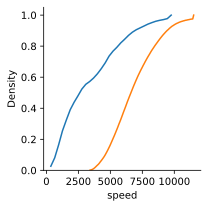

In [9]:
#sns.displot(res_un_df[(res_un_df.base == 'sidewalk') & (res_un_df.target=='sidewalk') & (res_un_df.dens==45)], x='speed', col='los', facet_kws={'sharey': False, 'sharex': True}, kind='kde')
fg = sns.FacetGrid(res_un_df[(res_un_df.base == 'sidewalk') & (res_un_df.target=='sidewalk') &(res_un_df.dens==45)], hue='los')
fg.map_dataframe(sns.histplot, x='speed', stat='density', cumulative=True, fill=False, element="poly")

In [2]:
sns.displot(res_un_df[(res_un_df.base == 'sidewalk') & (res_un_df.target=='sidewalk') & (res_un_df.dens==40)], x='dist', hue='los', facet_kws={'sharey': False, 'sharex': True}, element='poly', stat='probability', common_norm=True, cumulative=True)
#plt.xlim(0,50)
#plt.ylim(0.5,1)
#plt.plot([0.5,0.5], [0,100000])

NameError: name 'res_un_df' is not defined

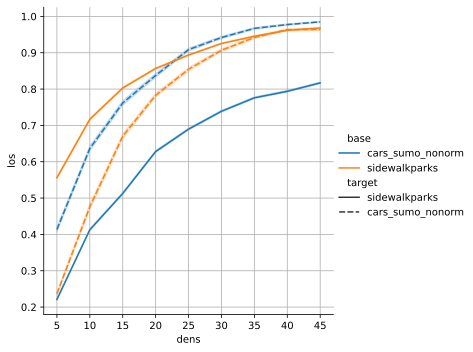

In [19]:
myres = res_un_df[res_un_df.base.isin(['cars_sumo_nonorm', 'sidewalkparks']) & res_un_df.target.isin(['cars_sumo_nonorm', 'sidewalkparks'])]
sns.relplot(data=myres, x='dens', y='los', kind='line', hue='base', style='target')
plt.grid()

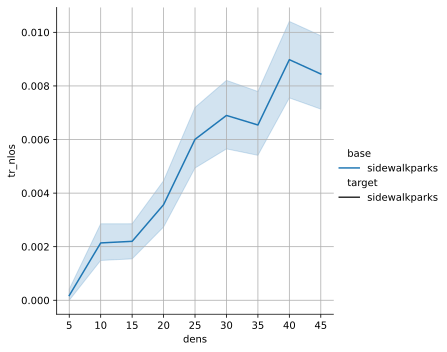

In [71]:
myres = res_un_df[res_un_df.base.isin(['sidewalkparks']) & res_un_df.target.isin(['sidewalkparks'])]
#sns.relplot(data=myres, x='dens', y='los', kind='line', hue='base', style='target')
sns.relplot(data=myres, x='dens', y='tr_nlos', kind='line', hue='base', style='target')
plt.grid()

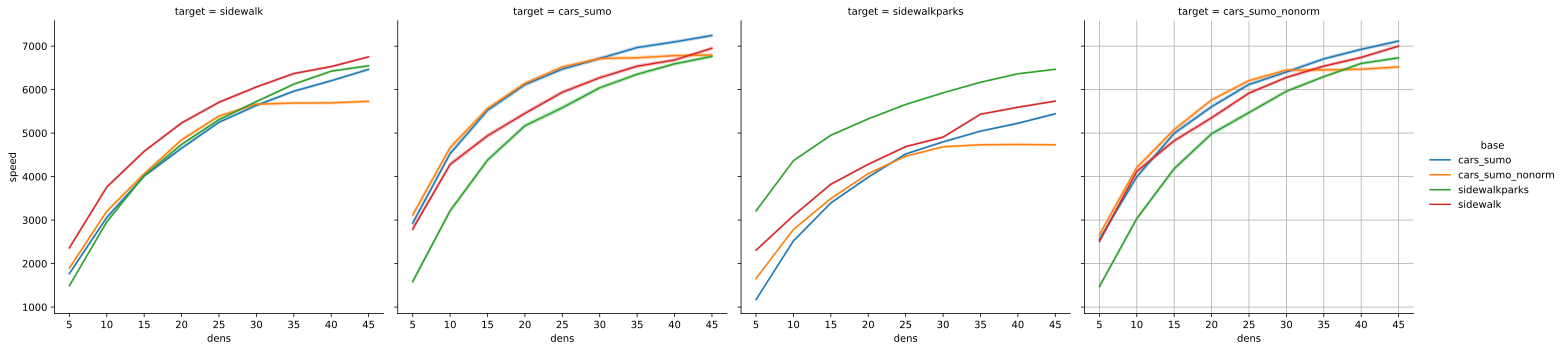

In [14]:
sns.relplot(data=res_un_df, x='dens', y='speed', kind='line', hue='base', col='target')
plt.grid()

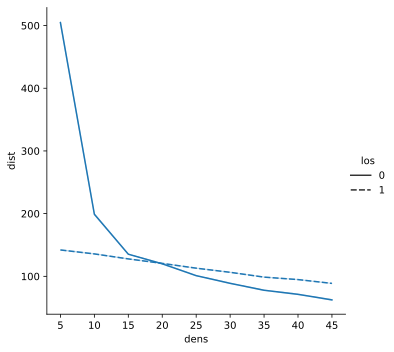

In [24]:
sns.relplot(data=res_un_df[(res_un_df.base == 'sidewalk') & (res_un_df.target=='sidewalk')], x='dens', y='dist', kind='line', style='los')

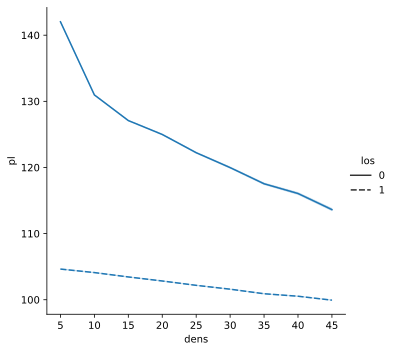

In [25]:
sns.relplot(data=res_un_df[(res_un_df.base == 'sidewalk') & (res_un_df.target=='sidewalk')], x='dens', y='pl', kind='line', style='los')

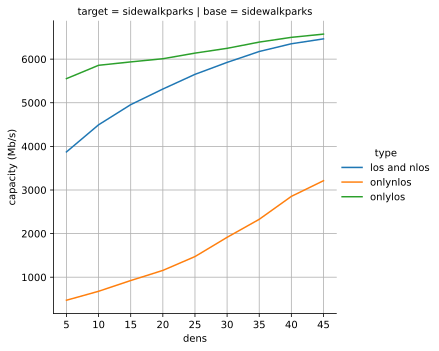

In [9]:
sns.relplot(data=res_df[res_df.target.isin(['sidewalkparks']) & res_df.base.isin(['sidewalkparks'])], x='dens', y='speed_m', hue='type', row='target', col='base', kind='line', facet_kws={'sharey': True, 'sharex': True}, )
for ax in plt.gcf().get_axes():
    ax.grid()
    ax.set_ylabel('capacity (Mb/s)')

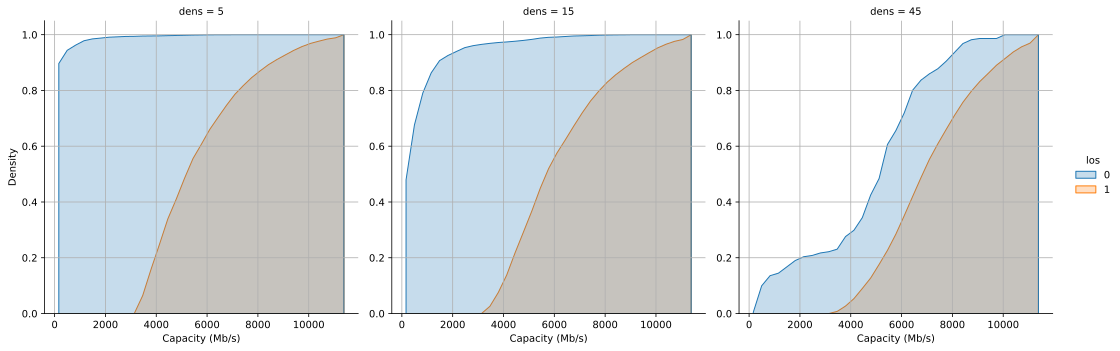

In [41]:
sns.displot(res_un_df[res_un_df.target.isin(['cars_sumo_nonorm']) & res_un_df.base.isin(['cars_sumo_nonorm']) & res_un_df.dens.isin([5,15,45])], x='speed', col='dens', facet_kws={'sharey': False, 'sharex': True}, stat='density', hue='los', common_norm=False, cumulative=True, element='poly')
for ax in plt.gcf().get_axes():
    ax.grid()
    ax.set_xlabel('Capacity (Mb/s)')
    #ax.set_xlim(0,2000)

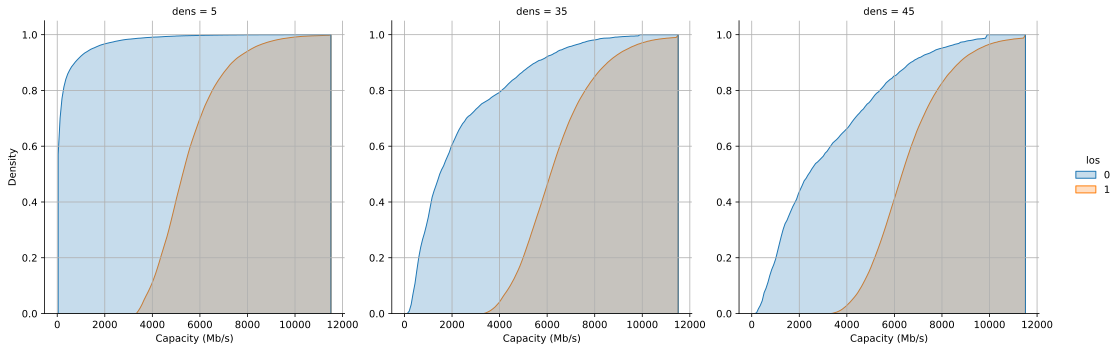

In [40]:
sns.displot(res_un_df[res_un_df.target.isin(['sidewalkparks']) & res_un_df.base.isin(['sidewalkparks']) & res_un_df.dens.isin([5,35,45])], x='speed', col='dens', facet_kws={'sharey': False, 'sharex': True}, stat='density', hue='los', common_norm=False, cumulative=True, element='poly')
for ax in plt.gcf().get_axes():
    ax.set_xlabel('Capacity (Mb/s)')
    ax.grid()

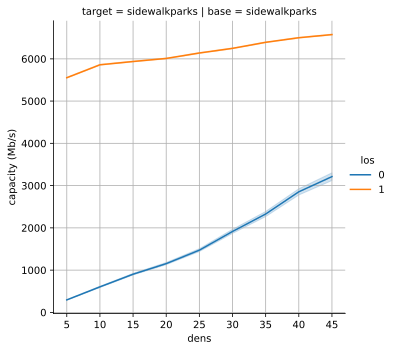

In [37]:
sns.relplot(data=res_un_df[res_un_df.target.isin(['cars_sumo_nonorm']) & res_un_df.base.isin(['cars_sumo_nonorm'])], x='dens', y='speed', hue='los', row='target', col='base', kind='line', facet_kws={'sharey': True, 'sharex': True})
for ax in plt.gcf().get_axes():
    ax.grid()
    ax.set_ylabel('capacity (Mb/s)')

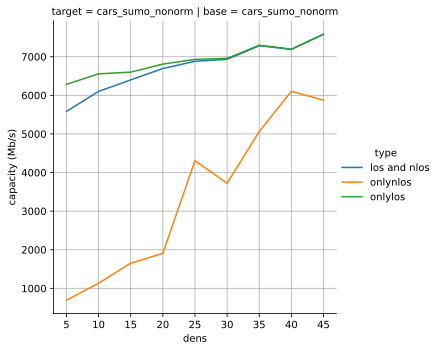

In [10]:
sns.relplot(data=res_df[res_df.target.isin(['cars_sumo_nonorm']) & res_df.base.isin(['cars_sumo_nonorm'])], x='dens', y='speed_m', hue='type', row='target', col='base', kind='line', facet_kws={'sharey': True, 'sharex': True})
for ax in plt.gcf().get_axes():
    ax.grid()
    ax.set_ylabel('capacity (Mb/s)')

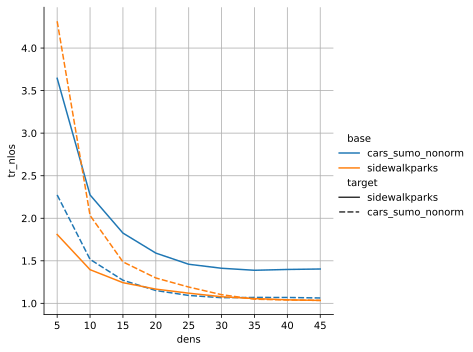

In [35]:
myres = res_df[res_df.base.isin(['sidewalkparks', 'cars_sumo_nonorm']) & res_df.target.isin(['sidewalkparks', 'cars_sumo_nonorm']) & res_df.type.isin(['los and nlos'])]

sns.relplot(data=myres, x='dens', y='tr_nlos', hue='base', style='target', kind='line', facet_kws={'sharey': True, 'sharex': True})
for ax in plt.gcf().get_axes():
    ax.grid()

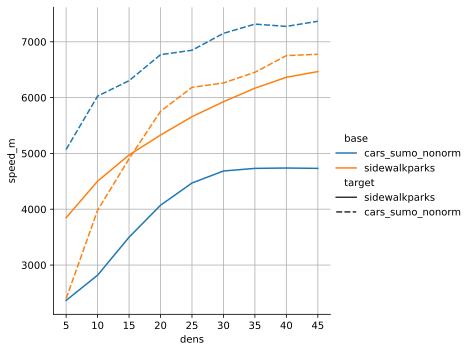

In [13]:
#myres= res_df[(res_df.type.isin(['los and nlos']))]
myres = res_df[res_df.base.isin(['sidewalkparks', 'cars_sumo_nonorm']) & res_df.target.isin(['sidewalkparks', 'cars_sumo_nonorm']) & res_df.type.isin(['los and nlos'])]

sns.relplot(data=myres, x='dens', y='speed_m', hue='base', style='target', kind='line', facet_kws={'sharey': True, 'sharex': True})
for ax in plt.gcf().get_axes():
    ax.grid()

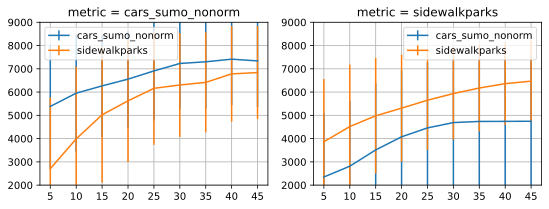

In [23]:


myres= res_df[(res_df.type.isin(['los and nlos'])) & res_df.base.isin(['sidewalkparks', 'cars_sumo_nonorm']) & res_df.target.isin(['sidewalkparks', 'cars_sumo_nonorm'])]

plt.figure(figsize=(9,3))
for t_i, target in enumerate(myres.base.unique()):
    ax = plt.subplot(1, len(myres.base.unique()),t_i+1)
    for b in myres.base.unique():
        this = myres[(myres.base == b) & (myres.target == target)].sort_values('dens')
        ax.errorbar(this.dens.values, this.speed_m.values, this.speed_std.values, label=b)
        #ax.fill_between(this.dens.values, (this.speed_m.values-this.speed_std.values), (this.speed_m.values+this.speed_std.values), alpha=0.5)
        ax.set_title(f'metric = {target}')
        ax.set_ylim(2000,9000)
        #print(this.dens.values, this.speed_mean.values, this.speed_ci.values)
        ax.set_xticks([5,10,15,20,25,30,35,40,45])
        #ax.set_ylim(0,500)
    ax.grid()
        #plt.grid()
    ax.legend()

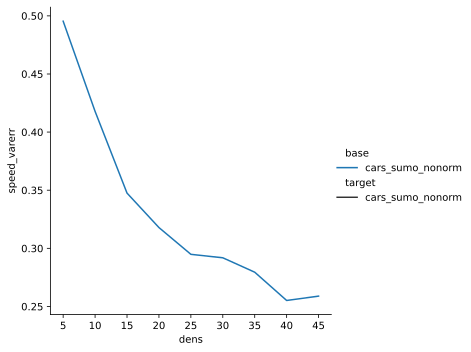

In [48]:
myres= res_df[(res_df.type.isin(['los and nlos'])) & res_df.base.isin(['cars_sumo_nonorm']) & res_df.target.isin(['cars_sumo_nonorm'])]
sns.relplot(data=myres, x='dens', y='speed_varerr', hue='base', style='target', kind='line')

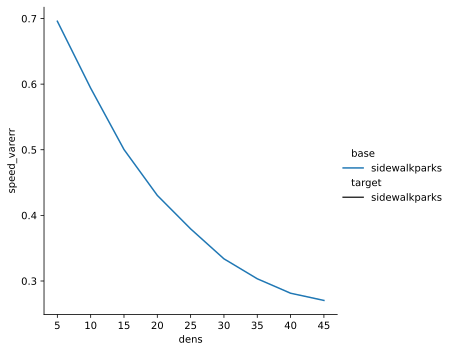

In [49]:
myres= res_df[(res_df.type.isin(['los and nlos'])) & res_df.base.isin(['sidewalkparks']) & res_df.target.isin(['sidewalkparks'])]
sns.relplot(data=myres, x='dens', y='speed_varerr', hue='base', style='target', kind='line')